In this series, I want to discuss the creation of a small library for training neural networks: `nntrain`. It's based off the excellent [part 2](https://course.fast.ai/) of Practical Deep Learning for Coders by Jeremy Howard, in which from lessons 13 to 18 (roughly) the development of the `miniai` library is discussed.

The library will build upon PyTorch. We'll try as much as possible to build from scratch to understand how it all works. Once the main functionality of components are implemented and verified, we can switch over to PyTorch's version. This is similar to how things are done in the course. However, this is not just a "copy / paste" of the course: on many occasions I take a different route, and most of the code is my own. That is not to say that all of this is meant to be extremely innovative, instead I had the following goals:

- Deeply understand the training of neural networks with a focus on PyTorch
- Try to create an even better narrative then what's presented in FastAI 🙉🤷‍♂️🙈
- Get hands-on experience with creating a library with [`nb_dev`](https://nbdev.fast.ai/)

`nb_dev` is another great project from the fastai community, which allows python libraries to be written in jupyter notebooks. This may sound a bit weird since the mainstream paradigm is to only do experimental work in notebooks. It has the advantage though that we can create the source code for our library in the very same environment in which we want to experiment and interact with our methods, objects and structure **while we are building the library**. For more details on why this is a good idea and other nice features of `nb_dev`, see [here](https://www.fast.ai/posts/2022-07-28-nbdev2.html).

So without further ado, let's start with where we left off in the previous [post](https://lucasvw.github.io/posts/10_nntrain_learner/):

## End of last post:

In the last two posts we build up the `learner` and `dataloader` module. In this post, we are going to use both the Dataloaders as well as the Learner object. From the naive MLP model we have been using so far, we will switch to a convolutional neural network (CNN) and investigate how we can improve performance by looking at the activations throughout the network. 

In [ ]:
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn
from nntrain.learner import *

In [ ]:
 #| export
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
from functools import partial
import fastcore.all as fc
import math
import torcheval.metrics as tem
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# For reproducability

def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

Since a CNN operates on a pixel grid instead of a flat array of pixel values, we have to change the data loading. For this we can use the `Dataloaders` module we have created in an earlier [post](https://lucasvw.github.io/posts/09_nntrain_ds/). By using the `hf_ds_collate_fn` with `flatten=False`, we keep the pixel grid in our data and end up with xb having a shape of `[batch, channels, height, width]`:

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)

bs = 1024

collate = partial(hf_ds_collate_fn, flatten=False)

dls = DataLoaders.from_hf_dd(hf_dd, batch_size=bs, collate_fn=collate)

xb = next(iter(dls.train))[0]
xb.shape

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1024, 1, 28, 28])

## Convolutional Neural Network

Next, let's create a simple CNN consisting of a couple of convolutions with ReLU activations in between:

In [ ]:
def conv_block(in_c, out_c, kernel_size=3, act=True):
    padding = kernel_size // 2    # don't lose pixels of the edges
    stride = 2                    # reduces the image size by factor of 2 in x and y directions
    conv = torch.nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
    if act: return nn.Sequential(conv, torch.nn.ReLU())
    else: return conv

The model defined below will receive images of shape 28x28, and since we use a stride of 2 in each convolution the image size will be reduced by a factor of 2 in both the x and y direction. Since we reduce the amount of values in the pixel grid by a factor of 4, we increase the number of kernels by a factor of 2 so that the data is reduced by a factor of 2 each time we apply a convolution.

In the very first convolution we go from 1 input channel to 8 output channels. To do that, we have to increase the kernel size from 3 to 5. Since for a kernel of size 3, we would have just 3x3 pixels (x 1 input channel) that would map to single position in the output grid. The output grid has 8 channels, so we would go from 9 (3x3x1) to 8 (1x1x8) values. Going from 9 to 8 values is practically no reduction, which doesn't allow the convolution to learn anything. So instead we take a kernel of size 5 so that we go from 25 (5x5x1) to 9 values.

In [ ]:
def cnn_layers():
    return nn.Sequential(                       # input image size=28x28
        conv_block(1 ,8, kernel_size=5),        # 14x14
        conv_block(8 ,16),                      # 7x7
        conv_block(16,32),                      # 4x4
        conv_block(32,64),                      # 2x2
        conv_block(64,10, act=False),           # 1x1
        nn.Flatten())
cnn_layers()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

Let's see how this trains:

epoch,mode,loss,accuracy
0,train,2.278,0.154
0,eval,2.302,0.100
1,train,2.231,0.193
1,eval,2.029,0.379
2,train,0.960,0.650
2,eval,0.717,0.728
3,train,0.597,0.781
3,eval,0.568,0.799
4,train,0.520,0.811
4,eval,0.508,0.816


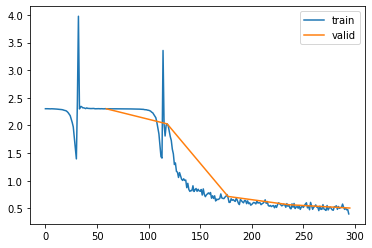

In [ ]:
set_seed(1)

subs = [ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(cnn_layers(), dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

Although the accuracy is better then what we had with the MLP model, this doesn't look good. The loss is going down and then spikes up to a large value. This happens twice before finally the loss is going down in a stable manner. To understand what's going on, we have to understand what's happening to the activations in the network. 

But before we do, it's important to realize that in the forward pass of neural networks we iteratively multiply the inputs to the model many times with many different (weight) matrices. Let's see how that works by using some artificial data, we generate 1000 random samples of data each with 10 features taken from a unit gaussian (mean=0 and standard deviation=1)

In [ ]:
x = torch.randn(10000, 10) 

Let's iteratively multiply these inputs also with a unit gausian weight matrix mapping from 10 input features to 10 output features and check the mean and standard deviation (std) after each iteration:

In [ ]:
for i in range(10):
    print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')
    w = torch.randn(10, 10)
    x = x@w

"x" multiplied 00 times: mean=    -0.003,   std=          1.000
"x" multiplied 01 times: mean=     0.013,   std=          3.317
"x" multiplied 02 times: mean=    -0.013,   std=          9.330
"x" multiplied 03 times: mean=    -0.009,   std=         32.389
"x" multiplied 04 times: mean=     0.484,   std=        103.563
"x" multiplied 05 times: mean=     2.104,   std=        299.863
"x" multiplied 06 times: mean=     4.431,   std=        948.056
"x" multiplied 07 times: mean=    -4.135,   std=       3229.121
"x" multiplied 08 times: mean=   -74.124,   std=      11527.234
"x" multiplied 09 times: mean=   -38.169,   std=      35325.461


We observe that iteratively multipliying input data (even if both input and weight matrix are unit gaussian) leads to unstable activations:

- the standard deviation grows exponentially
- initially the mean remains around 0, but eventually it starts to deviate. Probably because the standard deviation is getting larger and larger

This is a big problem for the training of neural networks as input data is passing through the network. When activations are ever increasing so are the gradients which causes the updates to the weights to become too large. 

Let's try the same with a weight matrix that has a smaller standard deviation:

In [ ]:
x = torch.randn(10000, 10) 

for i in range(10):    
    print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')
    w = torch.randn(10, 10) * 0.1 # reduce the standard deviation to 0.1
    x = x@w

"x" multiplied 00 times: mean=     0.004,   std=          1.001
"x" multiplied 01 times: mean=    -0.000,   std=          0.279
"x" multiplied 02 times: mean=    -0.000,   std=          0.072
"x" multiplied 03 times: mean=    -0.000,   std=          0.027
"x" multiplied 04 times: mean=    -0.000,   std=          0.011
"x" multiplied 05 times: mean=     0.000,   std=          0.003
"x" multiplied 06 times: mean=    -0.000,   std=          0.001
"x" multiplied 07 times: mean=     0.000,   std=          0.000
"x" multiplied 08 times: mean=    -0.000,   std=          0.000
"x" multiplied 09 times: mean=     0.000,   std=          0.000


This is not any better, all activations are about the same, and they are all zero! If this happens in a neural network, the network is not training at all.

## Activations

From the above it follows that it's important to keep track of the activations as data flows through the network. Let's try to build this into our framework.

To track the activations we can make use of PyTorch hooks: a function that you can attach to any `nn.Module` and which will be called after the module is being called either during the forward (`register_forward_hook()`) or backward pass (`register_backward_hook()`). Since it's important that we remove the hook after we have used it, let's create a small Hook class, that wraps this logic. We will also store the tracked metrics as attributes on this class.

In [ ]:
class Hook():
    def __init__(self, nr, layer, func):
        wrapped_func = partial(func, self) # pass the Hook object into the function
        self.hook = layer.register_forward_hook(wrapped_func)
        self.layer_name = f'{nr}_{layer.__class__.__name__}'
        
    def remove(self):
        self.hook.remove()

And let's create a Subscriber, that creates / removes the hooks and keeps track of the statistics. We will keep track of mean and std as the main metrics we have also been looking at above. Additionally we will keep track of the histogram counts for additional visibility into the activations.

In [ ]:
class ActivationStatsS(Subscriber):
    
    def __init__(self, modules, dead=None):
        self.modules = modules
        self.dead = dead
    
    def before_fit(self, learn):
        self.hooks = [Hook(i, module, partial(self.record_stats, learn)) for i, module in enumerate(self.modules)]
        
    def record_stats(self, learn, hook, layer, inp, outp):
        if learn.model.training:
            if not hasattr(hook, 'stats'): hook.stats = ([], [], [], [])
            acts = outp.detach().cpu()
            hook.stats[0].append(acts.mean())
            hook.stats[1].append(acts.std())
            if isinstance(self.dead, torch.Tensor):
                hook.stats[2].append((acts == self.dead).sum() / acts.numel())
            hook.stats[3].append(acts.histc(bins=50, min=-10, max=10))

    def after_fit(self, learn): 
        for h in self.hooks: h.remove()
        
    def plot(self, figsize=(15,4), dead=False):
        plots = 3 if dead else 2
        fig,axs = plt.subplots(1,plots, figsize=figsize)
        legend = []
        for h in self.hooks:
            axs[0].plot(h.stats[0])
            axs[0].set_title('mean')
            axs[1].plot(h.stats[1])
            axs[1].set_title('std')
            if dead:
                axs[2].plot(h.stats[2])
                axs[2].set_title('dead %')
                axs[2].set_ylim(0,1)
            legend.append(h.layer_name)
        plt.legend(legend);
        
    def plot_hist(self, figsize=None, log=True):
        if figsize is None: figsize = (10, len(self.hooks) * 4)
        fig,axs = plt.subplots(len(self.hooks), 1, figsize=figsize)
        for i, hook in enumerate(self.hooks):
            d = torch.stack(hook.stats[3]).T
            if log: d = d.log()
            axs[i].imshow(d, cmap='Blues', origin='lower', aspect='auto')
            axs[i].set_title(hook.layer_name)
            axs[i].set_yticks(np.arange(0, 50, 5), np.arange(-10, 10, 2))

In [ ]:
set_seed(1)

model = cnn_layers()

# show activation stats on all ReLU layers
modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules, dead=torch.tensor(0.0))

subs = [act_stats,
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

Let's have a look at the mean and std's of the layers as we progressively train the model. On the horizontal axis the number of batches are displayed and the coloured lines depict the mean and std respectively of the activations in the layers we are tracking (all the ReLU layers in our model):

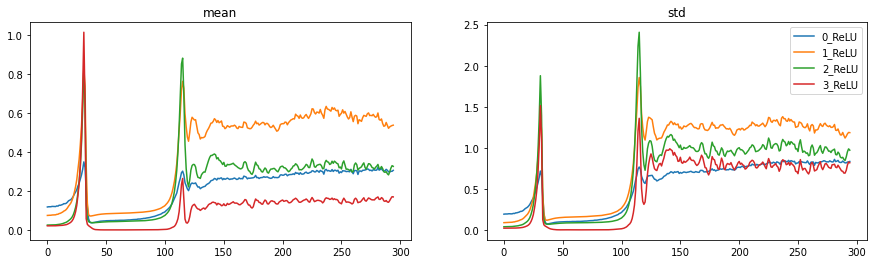

In [ ]:
act_stats.plot()

And let's also have a look at the histogram plots. The horizontal axis we have again number of batches. Vertically we display a histogram (to help with the colorscale, we actually display the log of the histogram counts) as a heatmap: e.g. high counts in a bin correspond to a dark blue color. The vertical axis goes from -10 to 10, so a dark blue horizontal line around zero indicates that through many batches all (most) activations are close to zero. Since we are tracking the stats of ReLU layers there are no counts below zero.

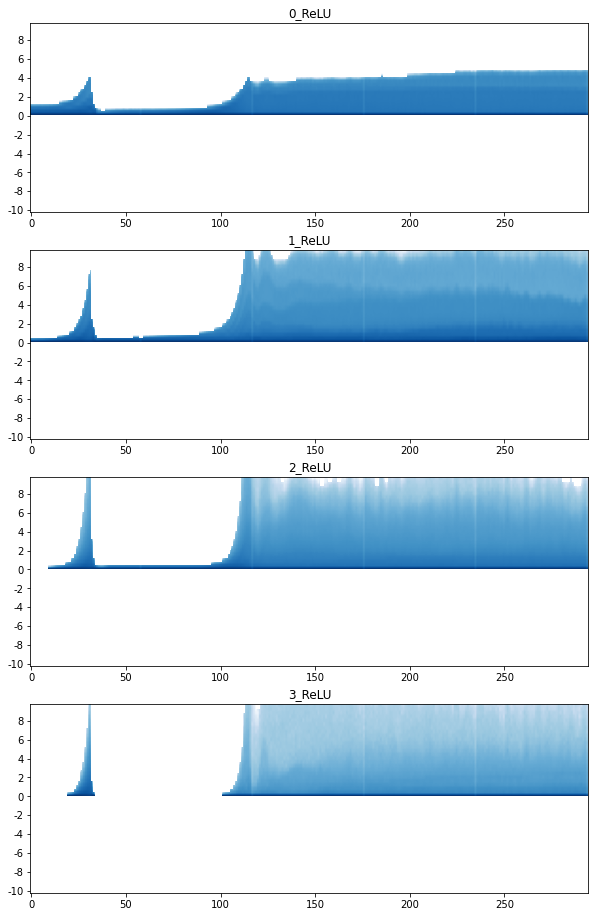

In [ ]:
act_stats.plot_hist()

Finally, since we are tracking the ReLU layers, we can have a look a the percentage of activations that are "dead", i.e. that have a value of 0.0:

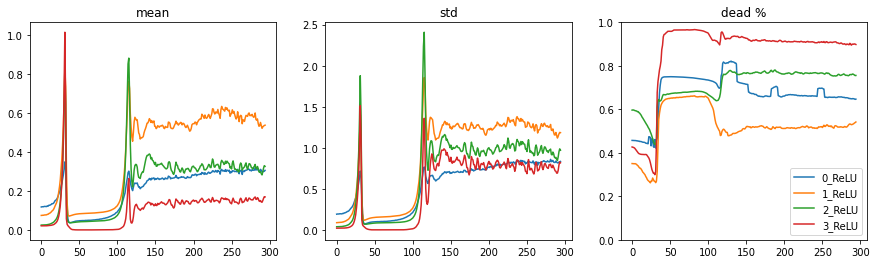

In [ ]:
act_stats.plot(dead=True)

And indeed all these plots don't look good. In the beginning the std's are way too small, which then starts to increase exponentially and then crashes back to zero. This patterns repeats once again, and then finally the std's stabilize around a value somewhat in the range of 1. 

It's thus important that activations remain more or less unit gaussian throughout the network. We are going to have a look at a couple of ways to deal with this. First up: initialization of the network

## Initialization

Initialization is the process of setting the weights *before* they are trained. This is done by drawing random numbers taken from some distribition.

With Xavier initialization, the weight matrices are initialized in such a way that activations taken from a unit gaussian don't explode or vanish as we have seen above. It turns out, that we have to scale the standard deviation by $1/\sqrt{n_{in}}$

In [ ]:
x = torch.randn(10000, 10) 

# reduce the standard deviation by a factor of 1/sqrt(10)
w3 = torch.randn(10, 10) * (1/10**0.5)

for i in range(10):
    x = x@w3
print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')

"x" multiplied 09 times: mean=    -0.002,   std=          0.882


And as you can see this works reasonably well! However, this doesn't solve everything. Since we also have activation functions sitting in between our matrix mulitplies. Activations typically squash the activations:

In [ ]:
x = torch.randn(10000, 10) 

# reduce the standard deviation by a factor of 1/sqrt(10)
w4 = torch.randn(10, 10) * (1/10**0.5)

for i in range(10):
    x = (x@w3).relu()
print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')

"x" multiplied 09 times: mean=     0.004,   std=          0.009


And as expected, everyhing has imploded to zero. It turns out that we can correct for this squashing by adding a gain. This is called Kaiming initialization. For example the gain for ReLU is $\sqrt{2}$:

In [ ]:
x = torch.randn(10000, 10)

# add a gain of sqrt(2)
w4 = torch.randn(10, 10) * (2**0.5)/(10**0.5)

for i in range(10):
    x = torch.nn.functional.relu((x@w4))
print(f'"x" multiplied {i:02d} times: mean={x.mean().item():10.3f},   std={x.std().item():15.3f}')

"x" multiplied 09 times: mean=     1.222,   std=          1.627


So let's apply Kaiming initialization to our model:

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d): torch.nn.init.kaiming_normal_(m.weight)

epoch,mode,loss,accuracy
0,train,1.408,0.561
0,eval,0.625,0.770
1,train,0.510,0.813
1,eval,0.465,0.833
2,train,0.416,0.850
2,eval,0.428,0.846
3,train,0.378,0.863
3,eval,0.389,0.864
4,train,0.356,0.871
4,eval,0.383,0.861


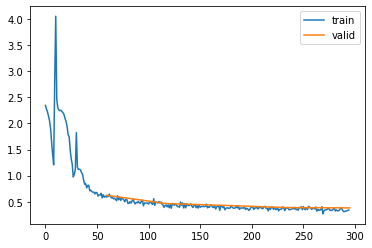

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules, dead=torch.tensor(0.0))

subs = [act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

That increases the performance from 82% to around 87%, also the loss graph looks a lot better. Let's have a look at our activation plots:

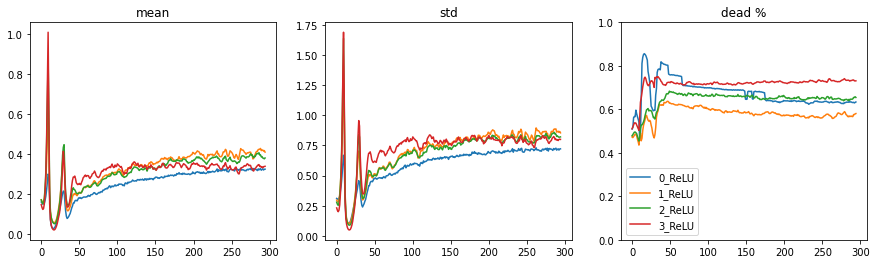

In [ ]:
act_stats.plot(dead=True)

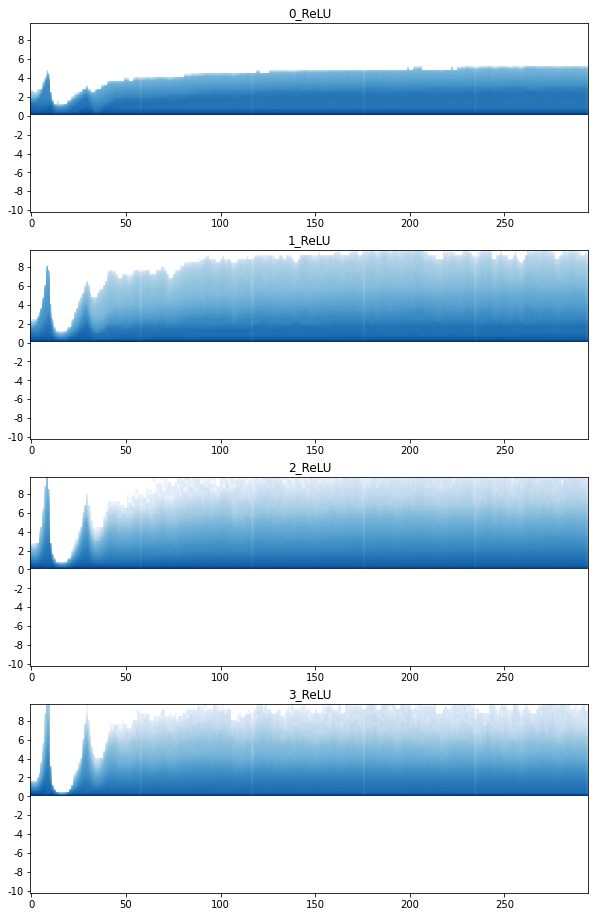

In [ ]:
act_stats.plot_hist()

## Normalisation

Instead of modifying the weight matrices, we can also look at the data itself. Let's try to standardize it before we pass it through the model:

In [ ]:
xb = next(iter(dls.train))[0]

In [ ]:
xb_mean = xb.mean()
xb_std = xb.std()

In [ ]:
class NormalizationS(Subscriber):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def before_batch(self, learn):
        learn.batch = [(learn.batch[0] - self.mean) / self.std, learn.batch[1]]

epoch,mode,loss,accuracy
0,train,0.919,0.689
0,eval,0.513,0.808
1,train,0.430,0.843
1,eval,0.414,0.852
2,train,0.375,0.864
2,eval,0.395,0.858
3,train,0.338,0.876
3,eval,0.367,0.864
4,train,0.323,0.882
4,eval,0.362,0.866


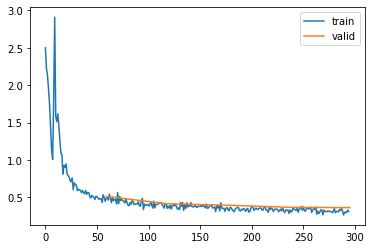

In [ ]:
set_seed(1)

model = cnn_layers().apply(init_weights)

modules = [module for module in model.modules() if isinstance(module, nn.ReLU)]
act_stats = ActivationStatsS(modules, dead=torch.tensor(0.0))

norm = NormalizationS(xb_mean, xb_std)

subs = [norm, 
        act_stats,
        ProgressS(True),
        MetricsS(accuracy=tem.MulticlassAccuracy()),
        DeviceS(device)]

l = MomentumLearner(model, dls, F.cross_entropy, torch.optim.SGD, 0.1, subs)
l.fit(5)

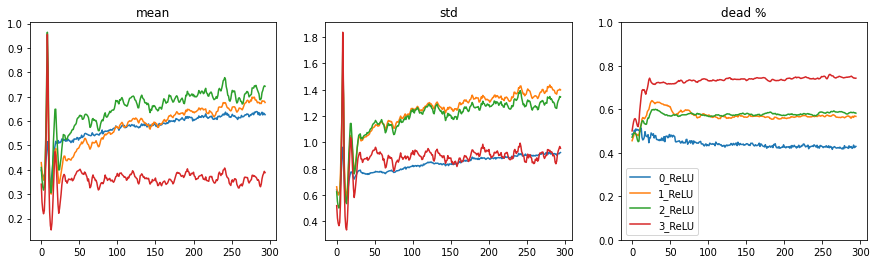

In [ ]:
act_stats.plot(dead=True)

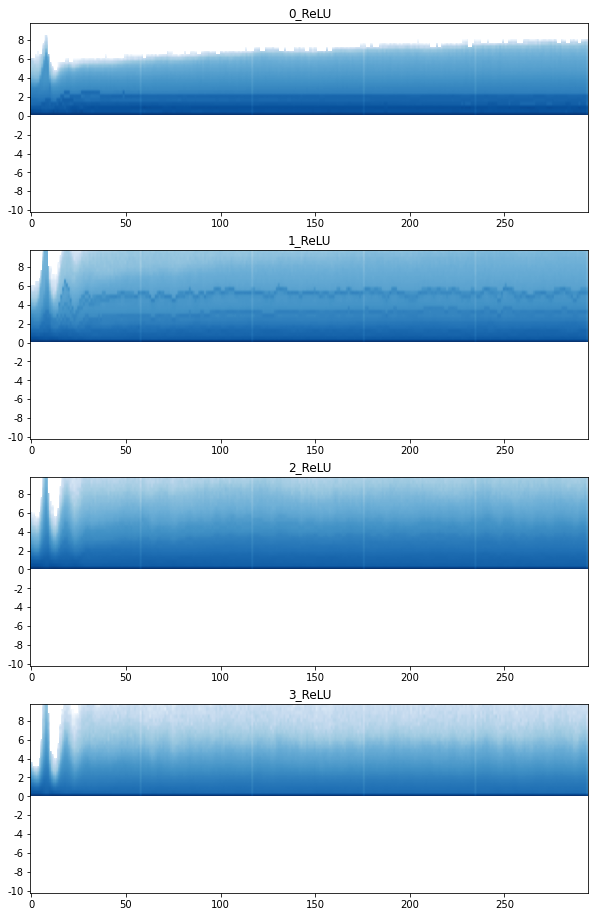

In [ ]:
act_stats.plot_hist()

## BatchNormalization